Training Techniques
=====

### Reference : http://www.hanbit.co.kr/store/books/look.php?p_code=B8475831198
--------

## 1. 매개변수 최적화

### 1.1 확률적 경사 하강법(SGD)

#### $W \leftarrow W - \nu * \frac {\partial L} {\partial W}$  
$W$ : 갱신할 가중치 매개변수  
$\nu$ : 학습률  
$\frac {\partial L} {\partial W}$ : W에 대한 손실함수의 기울기

- 비등방성 함수(방향에 따라 성질, 여기서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적인 단점이 있음

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 1.2 모멘텀(Momentum)

#### $v \leftarrow \alpha v - \nu \frac {\partial L} {\partial W}$
#### $W \leftarrow W + v$

$W$ : 갱신할 가중치 매개변수   
$\nu$ : 학습률   
$\frac {\partial L} {\partial W}$ : W에 대한 손실함수의 기울기  
$\alpha v$ : 물리에서의 지면 마찰이나 공기 저항에 해당함

- 기울기의 방향으로 힘을 받아 물체가 가속되는 물체 법칙을 차용한 방법
- 같은 방향으로 움직일 때 저항이 작은 반면 방향을 바꿀 경우 저항이 커진다

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum 
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # val 크기만큼의 0 행렬을 생성함
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### 1.3 AdaGrad

- 매개변수에 따른 학습률을 조정하는 최적화 방법
- 매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아짐
- 하지만 학습이 진행될수록 갱신 강도가 약해져 계속 학습하다보면 갱신량이 0이됨. 이를 해결한 최적화 방법인 RMSProp(지수 이동평균 사용)

#### $h \leftarrow h + \frac {\partial L} {\partial W} \bigodot \frac {\partial L} {\partial W}$
#### $W \leftarrow W - \nu \frac 1 {\sqrt h} \frac {\partial L} {\partial W}$

$W$ : 갱신할 가중치 매개변수   
$\nu$ : 학습률   
$\frac {\partial L} {\partial W}$ : W에 대한 손실함수의 기울기  
$\alpha v$ : 물리에서의 지면 마찰이나 공기 저항에 해당함  
$h$ : 기존 기울기 값을 제곱하여 더해주는 상수  
$\bigodot$ : 원소별 곱셈  

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 1.4 Adam

- Momentum과 AdaGrad의 방법을 융합한 최적화 기법
- 하이퍼 파라미터에 대한 편향 보정이 가능

## 2. 가중치의 초깃값

- 오버피팅을 방지하기 위해 가중치 감소(weight decay) 방법을 사용함.
- 이를 통해 가중치 매개변수의 값이 작아지도록 학습하는 것이 가능하다

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드 수
hidden_layer_size = 5  # 은닉층의 수
activations = {}  # 이곳에 활성화한 결과를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

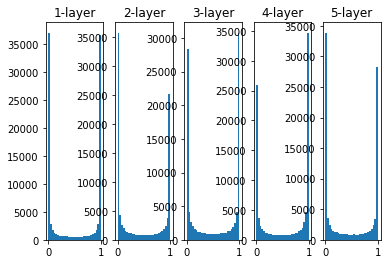

In [6]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 활성화값이 0과 1에 치우쳐져 있음
- 시그모이드 활성화 함수는 출력이 0이나 1에 가까워질수록 미분값으로 0에 가까운 값을 출력함
- 이로 인해 역전파의 기울기값이 점점 작아져 사라지는 기울기 소실(gradient vanishing)문제가 발생함

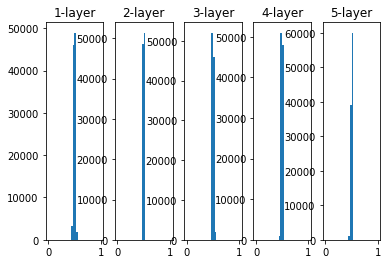

In [7]:
# 표준편차를 1로 바꾼 결과
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 출력값이 0.5 부근에 집중되어 있음
- 다수의 뉴런이 거의 같은 값을 출력하고 있어 표현력이 낮은 문제가 발생함(다수의 뉴런을 만든 의미가 없음)

### 2.1 Xavier 초기화

- 앞 계층의 노드가 n개라면 표준편차가 $\frac 1 {\sqrt n}$인 분포를 사용함
- 층이 깊어지면서 가중치의 값이 넓게 분포함
- Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과로 sigmoid, tanh 등 좌우 대칭 활성화 함수에 적합함

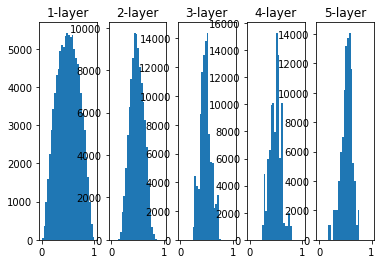

In [8]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드 수
hidden_layer_size = 5  # 은닉층의 수
activations = {}  # 이곳에 활성화한 결과를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

2.2 He
- Relu에 특화된 초깃값
- 앞 계층의 노드가 n개일 때 표준편차가 $\sqrt{\frac 2 n}$
- Relu는 음의 영역이 0이기 때문에 더 넓게 분포시키기 위해 2배의 계수를 사용한다

### 3. 배치 정규화

- 각 층의 활성화값이 적당히 분포되도록 조정한다
- 학습 속도 개선, 초깃값에 크게 의존하지 않음, 오버피팅 억제 등의 장점이 있다
- 학습 시 미니배치를 단위로 데이터의 분포가 평균 0, 분산 1이 되도록 정규화한다. 

#### $\mu_B \leftarrow \frac 1 m \sum_{i=1}^m x_i$  
#### $\sigma_B^2 \leftarrow \frac {1} {m} \sum_{i=1}^m (x_i - \mu_B)^2$
#### $\hat {x_i} \leftarrow \frac {x_i - \mu_B} {\sqrt {\sigma_B^2 + \epsilon}}$

### 4. 오버피팅

오버피팅은 주로 다음의 두 경우에서 발생함  
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

오버피팅 해결방법
- 오버피팅을 제어하기 위해 가중치 값을 줄여주는 weight decay 방법을 사용함
- 이를 위해 손실함수에 L1, L2 규제를 가하기도 함

### 4.1 Dropout

- 뉴런을 임의로 삭제하면서 학습하는 방법
- 시험할 때는 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력한다

In [9]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.droppout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, tran_fig=True):
        if train_fig:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

### 5. 적절한 하이퍼파라미터 값 찾기

- 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등
- 이를 위해 검증데이터 활용 및 하이퍼파라미터의 범위를 대략적으로 지정하는 최적화 방법이 효과적이다